In [1]:
import pandas as pd
import numpy as np
import datetime

# Import data for Top 10 most capitalized CC

In [2]:
from yahoo_fin.stock_info import get_data
CC = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 'BNB-USD', 'EOS-USD', 'ADA-USD', 'LINK-USD', 'XLM-USD']
MarketCap = pd.DataFrame()
for cc in CC:
    MarketCap[cc] = get_data(cc, '1/1/2019', datetime.date.today(),True, '1wk')['adjclose']
MarketCap_returns = np.log(MarketCap/ MarketCap.shift(1)).fillna(value=0)

# Import data for Top 10 most Liquid CC, with highest mean trading volume

In [3]:
from yahoo_fin.stock_info import get_data
CC = ['BTC-USD','ETH-USD','BCH-USD','LTC-USD','EOS-USD','XRP-USD','TRX-USD','ETC-USD','ADA-USD','XLM-USD']
Liquid = pd.DataFrame()
for cc in CC:
    Liquid[cc] = get_data(cc, '1/1/2019', datetime.date.today(),True, '1wk')['adjclose']
Liquid_returns = np.log(Liquid/ Liquid.shift(1)).fillna(value=0)

In [4]:
from functools import reduce
def std(w,cov):
    return np.sqrt(reduce(np.dot,[w,cov,w.T]))

In [5]:
def getSharpeFromWeights(weights,returns):
    expected_return = sum(weights*returns.mean())
    Std = std(weights, returns.cov()) 
    sharpeRatio = ((expected_return - 0)/Std)
    return sharpeRatio

In [6]:
def getUtilityFromWeights(weights,returns):
    expected_return = sum(weights*returns.mean())
    Var = std(weights, returns.cov()) * std(weights, returns.cov())
    Utility = (expected_return - Var/2)
    return Utility

In [36]:
def getRealReturnFromWeights(i,weights,returns):
    realreturn = sum(weights*returns.iloc[i])
    return realreturn

In [7]:
def getLongOnlyWeights(returns):
    from pypfopt.efficient_frontier import EfficientFrontier
    mean = returns.mean()
    cov = returns.cov()
    ef1 = EfficientFrontier(mean,cov,weight_bounds=(0, 1))
    LongOnly_weights = ef1.max_sharpe(risk_free_rate= 0.0)
    LongOnly_weights = ef1.clean_weights() 
    
    weights = np.array([1/len(LongOnly_weights) for x in range(len(LongOnly_weights))])
    for i in range(0,len(LongOnly_weights)):
        weights[i]= list(LongOnly_weights.values())[i]
    return weights

In [8]:
def getLongAndShortWeights(returns):
    from pypfopt.efficient_frontier import EfficientFrontier
    mean = returns.mean()
    cov = returns.cov()
    ef2 = EfficientFrontier(mean,cov,weight_bounds=(-1, 1))
    LongAndShort_weights = ef2.max_sharpe(risk_free_rate= 0.0)
    LongAndShort_weights = ef2.clean_weights()    
    
    weights = np.array([1/len(LongAndShort_weights) for x in range(len(LongAndShort_weights))])
    for i in range(0,len(LongAndShort_weights)):
        weights[i]= list(LongAndShort_weights.values())[i]
    
    return weights

In [37]:
def appendData(dataframe, weights, returns, i, model):
    expected_return = sum(weights*returns.iloc[0:i].mean())
    real_return = sum(weights*returns.iloc[i])
    Std = std(weights, returns.iloc[0:i].cov()) 
    sharpe = ((expected_return - 0)/Std)
    dataframe = dataframe.append(pd.Series({'Portfolio Model': model,
                                            'Expected Returns' : expected_return, 
                                            'Real Returns' : real_return,
                                            'Portfolio Std' : Std,
                                            'Sharpe Ratio': sharpe}, 
                                            name = returns.iloc[i].name))
    return dataframe
    

In [136]:
dataframe = pd.DataFrame()
sharperatio = pd.DataFrame()
utility = pd.DataFrame()
realreturn = pd.DataFrame()

for i in range(73, 95):
    
    liquid_truncated_returns = Liquid_returns.iloc[0:i] 
    marketcap_truncated_returns = MarketCap_returns.iloc[0:i]
    
    liquid_capm_longonly_weights       = getLongOnlyWeights(liquid_truncated_returns)
    liquid_capm_longandshort_weights   = getLongAndShortWeights(liquid_truncated_returns)
    marketcap_capm_longonly_weights    = getLongOnlyWeights(marketcap_truncated_returns)
    marketcap_capm_longandshort_weights= getLongAndShortWeights(marketcap_truncated_returns)
    liquid_equal_weights               = np.array([1/len(Liquid_returns.mean()) for x in range(len(Liquid_returns.mean()))])
    marketcap_equal_weights            = np.array([1/len(MarketCap_returns.mean()) for x in range(len(MarketCap_returns.mean()))])
    
    liquid_capm_longonly_sharpe        = getSharpeFromWeights(liquid_capm_longonly_weights,liquid_truncated_returns)
    liquid_capm_longandshort_sharpe    = getSharpeFromWeights(liquid_capm_longandshort_weights,liquid_truncated_returns)
    marketcap_capm_longonly_sharpe     = getSharpeFromWeights(marketcap_capm_longonly_weights, marketcap_truncated_returns)
    marketcap_capm_longandshort_sharpe = getSharpeFromWeights(marketcap_capm_longandshort_weights, marketcap_truncated_returns)
    liquid_equal_sharpe                = getSharpeFromWeights(liquid_equal_weights, liquid_truncated_returns)
    marketcap_equal_sharpe             = getSharpeFromWeights(marketcap_equal_weights, marketcap_truncated_returns)
    sharperatio = sharperatio.append(pd.Series({'Liquid CAPM LongOnly': liquid_capm_longonly_sharpe,
                                            'Liquid CAPM LongAndShort' : liquid_capm_longandshort_sharpe, 
                                            'Liquid Equal' : liquid_equal_sharpe,
                                            'MarketCap CAPM LongOnly' : marketcap_capm_longonly_sharpe,
                                            'MarketCap CAPM LongAndShort' : marketcap_capm_longandshort_sharpe, 
                                            'MarketCap Equal' : marketcap_equal_sharpe}, 
                                            name = Liquid_returns.iloc[i].name))
    
    liquid_capm_longonly_utility        = getUtilityFromWeights(liquid_capm_longonly_weights,liquid_truncated_returns)
    liquid_capm_longandshort_utility    = getUtilityFromWeights(liquid_capm_longandshort_weights,liquid_truncated_returns)
    marketcap_capm_longonly_utility     = getUtilityFromWeights(marketcap_capm_longonly_weights, marketcap_truncated_returns)
    marketcap_capm_longandshort_utility = getUtilityFromWeights(marketcap_capm_longandshort_weights, marketcap_truncated_returns)
    liquid_equal_utility                = getUtilityFromWeights(liquid_equal_weights, liquid_truncated_returns)
    marketcap_equal_utility             = getUtilityFromWeights(marketcap_equal_weights, marketcap_truncated_returns)
    
    utility = utility.append(pd.Series({'Liquid CAPM LongOnly': liquid_capm_longonly_utility,
                                            'Liquid CAPM LongAndShort' : liquid_capm_longandshort_utility, 
                                            'Liquid Equal' : liquid_equal_utility,
                                            'MarketCap CAPM LongOnly' : marketcap_capm_longonly_utility,
                                            'MarketCap CAPM LongAndShort' : marketcap_capm_longandshort_utility, 
                                            'MarketCap Equal' : marketcap_equal_utility}, 
                                            name = Liquid_returns.iloc[i].name))
    
    liquid_capm_longonly_realreturn        = (getRealReturnFromWeights(i,liquid_capm_longonly_weights,Liquid_returns))
    liquid_capm_longandshort_realreturn    = (getRealReturnFromWeights(i,liquid_capm_longandshort_weights,Liquid_returns))
    marketcap_capm_longonly_realreturn     = (getRealReturnFromWeights(i,marketcap_capm_longonly_weights, MarketCap_returns))
    marketcap_capm_longandshort_realreturn = (getRealReturnFromWeights(i,marketcap_capm_longandshort_weights, MarketCap_returns))
    liquid_equal_realreturn                = (getRealReturnFromWeights(i,liquid_equal_weights, Liquid_returns))
    marketcap_equal_realreturn             = (getRealReturnFromWeights(i,marketcap_equal_weights, MarketCap_returns))
    
    
    realreturn = realreturn.append(pd.Series({'Liquid CAPM LongOnly': liquid_capm_longonly_realreturn,
                                            'Liquid CAPM LongAndShort' : liquid_capm_longandshort_realreturn, 
                                            'Liquid Equal' : liquid_equal_realreturn,
                                            'MarketCap CAPM LongOnly' : marketcap_capm_longonly_realreturn,
                                            'MarketCap CAPM LongAndShort' : marketcap_capm_longandshort_realreturn, 
                                            'MarketCap Equal' : marketcap_equal_realreturn}, 
                                            name = Liquid_returns.iloc[i].name))
    
    index = sharpe_list.index(max(sharpe_list))
    #print(index)
    #print(sharpe_list)
    #print(utility_list)
    
    if index == 0:
        dataframe = appendData(dataframe, liquid_capm_longonly_weights, Liquid_returns,i, "liquid_capm_longonly")
    elif index ==1:
        dataframe = appendData(dataframe, liquid_capm_longandshort_weights, Liquid_returns,i, "liquid_capm_longandshort")
    elif index ==2:
        dataframe = appendData(dataframe, marketcap_capm_longonly_weights, MarketCap_returns,i, " marketcap_capm_longonly")
    elif index ==3:
        dataframe = appendData(dataframe, marketcap_capm_longandshort_weights, MarketCap_returns,i, "marketcap_capm_longandshort")
    elif index ==4:
        dataframe = appendData(dataframe, liquid_equal_weights, Liquid_returns,i, "liquid_equal")
    elif index ==5:
        dataframe = appendData(dataframe, marketcap_equal_weights, MarketCap_returns,i, " marketcap_equal")

In [146]:
def table_data(dataframe,Name,q):
    if Name == "Mean":
        data = dataframe.mean().tolist()
    elif Name == "Std":
        data = dataframe.std().tolist()
    else:
        data = dataframe.quantile(q).tolist()
        
    for i in range(0,len(data)):
        data[i] = round(data[i],3)
    data.insert(0,Name)
    return data

In [54]:
from prettytable import PrettyTable

In [131]:
x1 = PrettyTable(["","Liquid CAPM L&S", "Liquid CAPM L","Liquid 1/N", 
                 "MarketCap CAPM L&S","MarketCap CAPM L", "MarketCap Equal" ])
x1.padding_width = 1
x1.add_row(["N",22,22,22,22,22,22])
x1.add_row(table_data(sharperatio,"Mean",0))
x1.add_row(table_data(sharperatio,"Min",0))
x1.add_row(table_data(sharperatio,"q1",0.25))
x1.add_row(table_data(sharperatio,"Median",0.5))
x1.add_row(table_data(sharperatio,"q3",0.75))
x1.add_row(table_data(sharperatio,"Max",1))
x1.add_row(table_data(sharperatio,"Std",1))

In [132]:
print(x1)

+--------+-----------------+---------------+------------+--------------------+------------------+-----------------+
|        | Liquid CAPM L&S | Liquid CAPM L | Liquid 1/N | MarketCap CAPM L&S | MarketCap CAPM L | MarketCap Equal |
+--------+-----------------+---------------+------------+--------------------+------------------+-----------------+
|   N    |        22       |       22      |     22     |         22         |        22        |        22       |
|  Mean  |      0.233      |     0.112     |   0.026    |       0.338        |      0.193       |      0.072      |
|  Min   |      0.207      |     0.102     |   0.003    |       0.313        |      0.163       |      0.045      |
|   q1   |      0.223      |     0.106     |   0.017    |        0.33        |      0.175       |      0.062      |
| Median |      0.235      |     0.109     |   0.024    |       0.338        |      0.192       |       0.07      |
|   q3   |      0.245      |      0.12     |   0.033    |       0.348   

In [133]:
x2 = PrettyTable(["","Liquid CAPM L&S", "Liquid CAPM L","Liquid 1/N", 
                 "MarketCap CAPM L&S","MarketCap CAPM L", "MarketCap Equal" ])
x2.padding_width = 1
x2.add_row(["N",22,22,22,22,22,22])
x2.add_row(table_data(utility,"Mean",0))
x2.add_row(table_data(utility,"Min",0))
x2.add_row(table_data(utility,"q1",0.25))
x2.add_row(table_data(utility,"Median",0.5))
x2.add_row(table_data(utility,"q3",0.75))
x2.add_row(table_data(utility,"Max",1))
x2.add_row(table_data(utility,"Std",1))

In [135]:
print(x2)

+--------+-----------------+---------------+------------+--------------------+------------------+-----------------+
|        | Liquid CAPM L&S | Liquid CAPM L | Liquid 1/N | MarketCap CAPM L&S | MarketCap CAPM L | MarketCap Equal |
+--------+-----------------+---------------+------------+--------------------+------------------+-----------------+
|   N    |        22       |       22      |     22     |         22         |        22        |        22       |
|  Mean  |      0.026      |     0.006     |   -0.003   |       0.051        |      0.018       |      0.002      |
|  Min   |      0.021      |     0.005     |   -0.006   |       0.046        |      0.013       |      -0.001     |
|   q1   |      0.024      |     0.006     |   -0.004   |       0.049        |      0.015       |      0.001      |
| Median |      0.026      |     0.006     |   -0.003   |       0.051        |      0.018       |      0.002      |
|   q3   |      0.028      |     0.007     |   -0.002   |       0.053   

In [141]:
x3 = PrettyTable(["","Liquid CAPM L&S", "Liquid CAPM L","Liquid 1/N", 
                 "MarketCap CAPM L&S","MarketCap CAPM L", "MarketCap Equal" ])
x3.padding_width = 1
x3.add_row(table_data(realreturn,"Mean",0))
x3.add_row(table_data(realreturn,"Std",1))

In [142]:
print(x3)

+------+-----------------+---------------+------------+--------------------+------------------+-----------------+
|      | Liquid CAPM L&S | Liquid CAPM L | Liquid 1/N | MarketCap CAPM L&S | MarketCap CAPM L | MarketCap Equal |
+------+-----------------+---------------+------------+--------------------+------------------+-----------------+
| Mean |      0.022      |     0.016     |   0.013    |        0.08        |      0.038       |       0.02      |
| Std  |      0.214      |     0.065     |    0.08    |       0.221        |      0.141       |      0.086      |
+------+-----------------+---------------+------------+--------------------+------------------+-----------------+


In [144]:
realreturn.mean()

Liquid CAPM LongAndShort       0.022236
Liquid CAPM LongOnly           0.015948
Liquid Equal                   0.013281
MarketCap CAPM LongAndShort    0.079859
MarketCap CAPM LongOnly        0.037801
MarketCap Equal                0.019547
dtype: float64

In [145]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Mean of real returns')

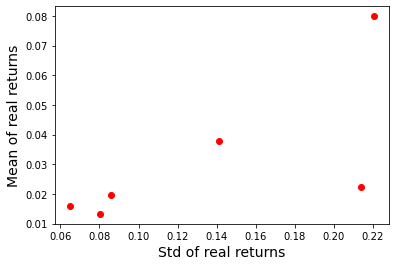

In [151]:
plt.scatter((realreturn.std().tolist()),(realreturn.mean().tolist()), c = 'r')
plt.xlabel('Std of real returns', fontsize=14)
plt.ylabel('Mean of real returns', fontsize=14)